## Generador de Prediccion Estandar

In [55]:
#Se limpia la memoria
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,799853,42.8,2848218,152.2,3362313,179.6
Vcells,63872614,487.4,303831654,2318.1,474700675,3621.7


In [56]:
semilla <- 100019
set.seed(semilla)

In [57]:
#cargo las librerias que necesito
require("data.table")
require("rpart")
require("rpart.plot")
#Contiene funciones para evaluar performance de la clasificación
library("ROCR")

In [58]:
setwd("C:/_MCD/Labo1/code")  #Establezco el Working Directory

In [59]:
dataset  <- fread("./datasets/competencia1_2022_FE_default.csv")
#dataset  <- fread("./datasets/competencia1_2022.csv")

## Agrego columna Binaria

In [60]:
dataset[ foto_mes==202101, 
         clase_binaria :=  ifelse( clase_ternaria=="CONTINUA", "NO", "SI" ) ]

In [61]:
dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar
dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

## Obviamente rpart no puede ver  clase_ternaria para predecir  clase_binaria

In [62]:
modelo  <- rpart(formula=   "clase_binaria ~ . -clase_ternaria",
                 data =      dtrain,  #los datos donde voy a entrenar
                 xval=       0,
                 cp=       -0.80114, #esto significa no limitar la complejidad de los splits
                 minsplit= 954,   #minima cantidad de registros para que se haga el split
                 minbucket=  130,   #tamaño minimo de una hoja
                 maxdepth=  7 )  #PRUEBO  una profundidad de 10

Ahora grafico el arbol, va a ser muy frondoso porque la profundidad es de 10

In [63]:
#prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0)

Ahora aplico al modelo  a los datos muevos  y genero la salida para kaggle

aplico el modelo a los datos nuevos

In [64]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo

prediccion es una matriz con dos columnas

In [65]:
dfinal  <- copy( dapply[ , list(numero_de_cliente) ] )
dfinal[ , prob_SI := prediccion[ , "SI"] ]

In [66]:
dfinal[ , azar := runif( nrow(dapply) ) ]

# ordeno en forma descentente, y cuando coincide la probabilidad, al azar
setorder( dfinal, -prob_SI, azar )

for( corte  in  c( 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000 ) )
{
  #le envio a los  corte  mejores,  de mayor probabilidad de prob_SI
  dfinal[ , Predicted := 0L ]
  dfinal[ 1:corte , Predicted := 1L ]

  fwrite( dfinal[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
           file= paste0( "./exp/competencia1/prediccion_con_corte_",  corte, ".csv"),
           sep=  "," )
}

creo la carpeta donde va el experimento

In [67]:
#dir.create( "./exp/competencia1" ) 

Hago lo mismo con train para evaluar en entrenamiento

In [68]:
prediccion  <- predict( modelo, dtrain , type = "prob") #aplico el modelo

dtrain[ , prob_SI := prediccion[ , "SI"] ]
dtrain[ , azar := runif( nrow(dtrain) ) ]
setorder( dtrain, -prob_SI, azar )

for( corte  in  c( 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000 ) )
{
  #le envio a los  corte  mejores,  de mayor probabilidad de prob_SI
  dtrain[ , Predicted := 0L ]
  dtrain[ 1:corte , Predicted := 1L ]

    dtrain[, clase := 0]
    dtrain[ clase_ternaria=='BAJA+2' ,   clase:= 1]
    
    #Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Calculo la ganancia
dtrain[  , ganancia:= kFPGain ] #-1250
dtrain[ clase_ternaria=='BAJA+2' ,   ganancia:= kTPGain] #48750
sum( dtrain$ganancia )

gan <- sum( dtrain[ dtrain$Predicted==1, ganancia] )

#TP
truepositive <- sum(dtrain$Predicted*dtrain[,clase])

#Incentivados Totales
incentivados <- sum(dtrain$Predicted)
print(paste("      Corte:",corte))
print(paste("      La Ganancia es:", gan))
print(paste("      TP:", truepositive))
print(paste("      Incentivados:",incentivados))
print("     ")
}

[1] "      Corte: 7500"
[1] "      La Ganancia es: 25240000"
[1] "      TP: 503"
[1] "      Incentivados: 7500"
[1] "     "
[1] "      Corte: 8000"
[1] "      La Ganancia es: 25360000"
[1] "      TP: 517"
[1] "      Incentivados: 8000"
[1] "     "
[1] "      Corte: 8500"
[1] "      La Ganancia es: 25240000"
[1] "      TP: 528"
[1] "      Incentivados: 8500"
[1] "     "
[1] "      Corte: 9000"
[1] "      La Ganancia es: 24880000"
[1] "      TP: 536"
[1] "      Incentivados: 9000"
[1] "     "
[1] "      Corte: 9500"
[1] "      La Ganancia es: 25080000"
[1] "      TP: 551"
[1] "      Incentivados: 9500"
[1] "     "
[1] "      Corte: 10000"
[1] "      La Ganancia es: 25120000"
[1] "      TP: 564"
[1] "      Incentivados: 10000"
[1] "     "
[1] "      Corte: 10500"
[1] "      La Ganancia es: 24600000"
[1] "      TP: 570"
[1] "      Incentivados: 10500"
[1] "     "
[1] "      Corte: 11000"
[1] "      La Ganancia es: 24080000"
[1] "      TP: 576"
[1] "      Incentivados: 11000"
[1] "     "


### Curva ROC

In [69]:
modelo

n= 161342 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 161342 1514 NO (0.9906162066 0.0093837934)  
    2) ctrx_quarter>=13.5 152942  803 NO (0.9947496437 0.0052503563)  
      4) mv_status01< 8 148384  683 NO (0.9953970779 0.0046029221)  
        8) ctrx_quarter>=37.5 133545  330 NO (0.9975289228 0.0024710772)  
         16) mpayroll>=8222.14 76831   51 NO (0.9993362054 0.0006637946)  
           32) mpayroll< 1683172 76701   48 NO (0.9993741933 0.0006258067)  
             64) cliente_edad< 63.5 73374   37 NO (0.9994957342 0.0005042658)  
              128) cliente_antiguedad>=47.5 59321   17 NO (0.9997134236 0.0002865764) *
              129) cliente_antiguedad< 47.5 14053   20 NO (0.9985768163 0.0014231837) *
             65) cliente_edad>=63.5 3327   11 NO (0.9966937181 0.0033062819)  
              130) ccomisiones_otras>=3 3183    7 NO (0.9978008168 0.0021991832) *
              131) ccomisiones_otras< 3 144    4 NO (0.9722222222 0.0277777778) 

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


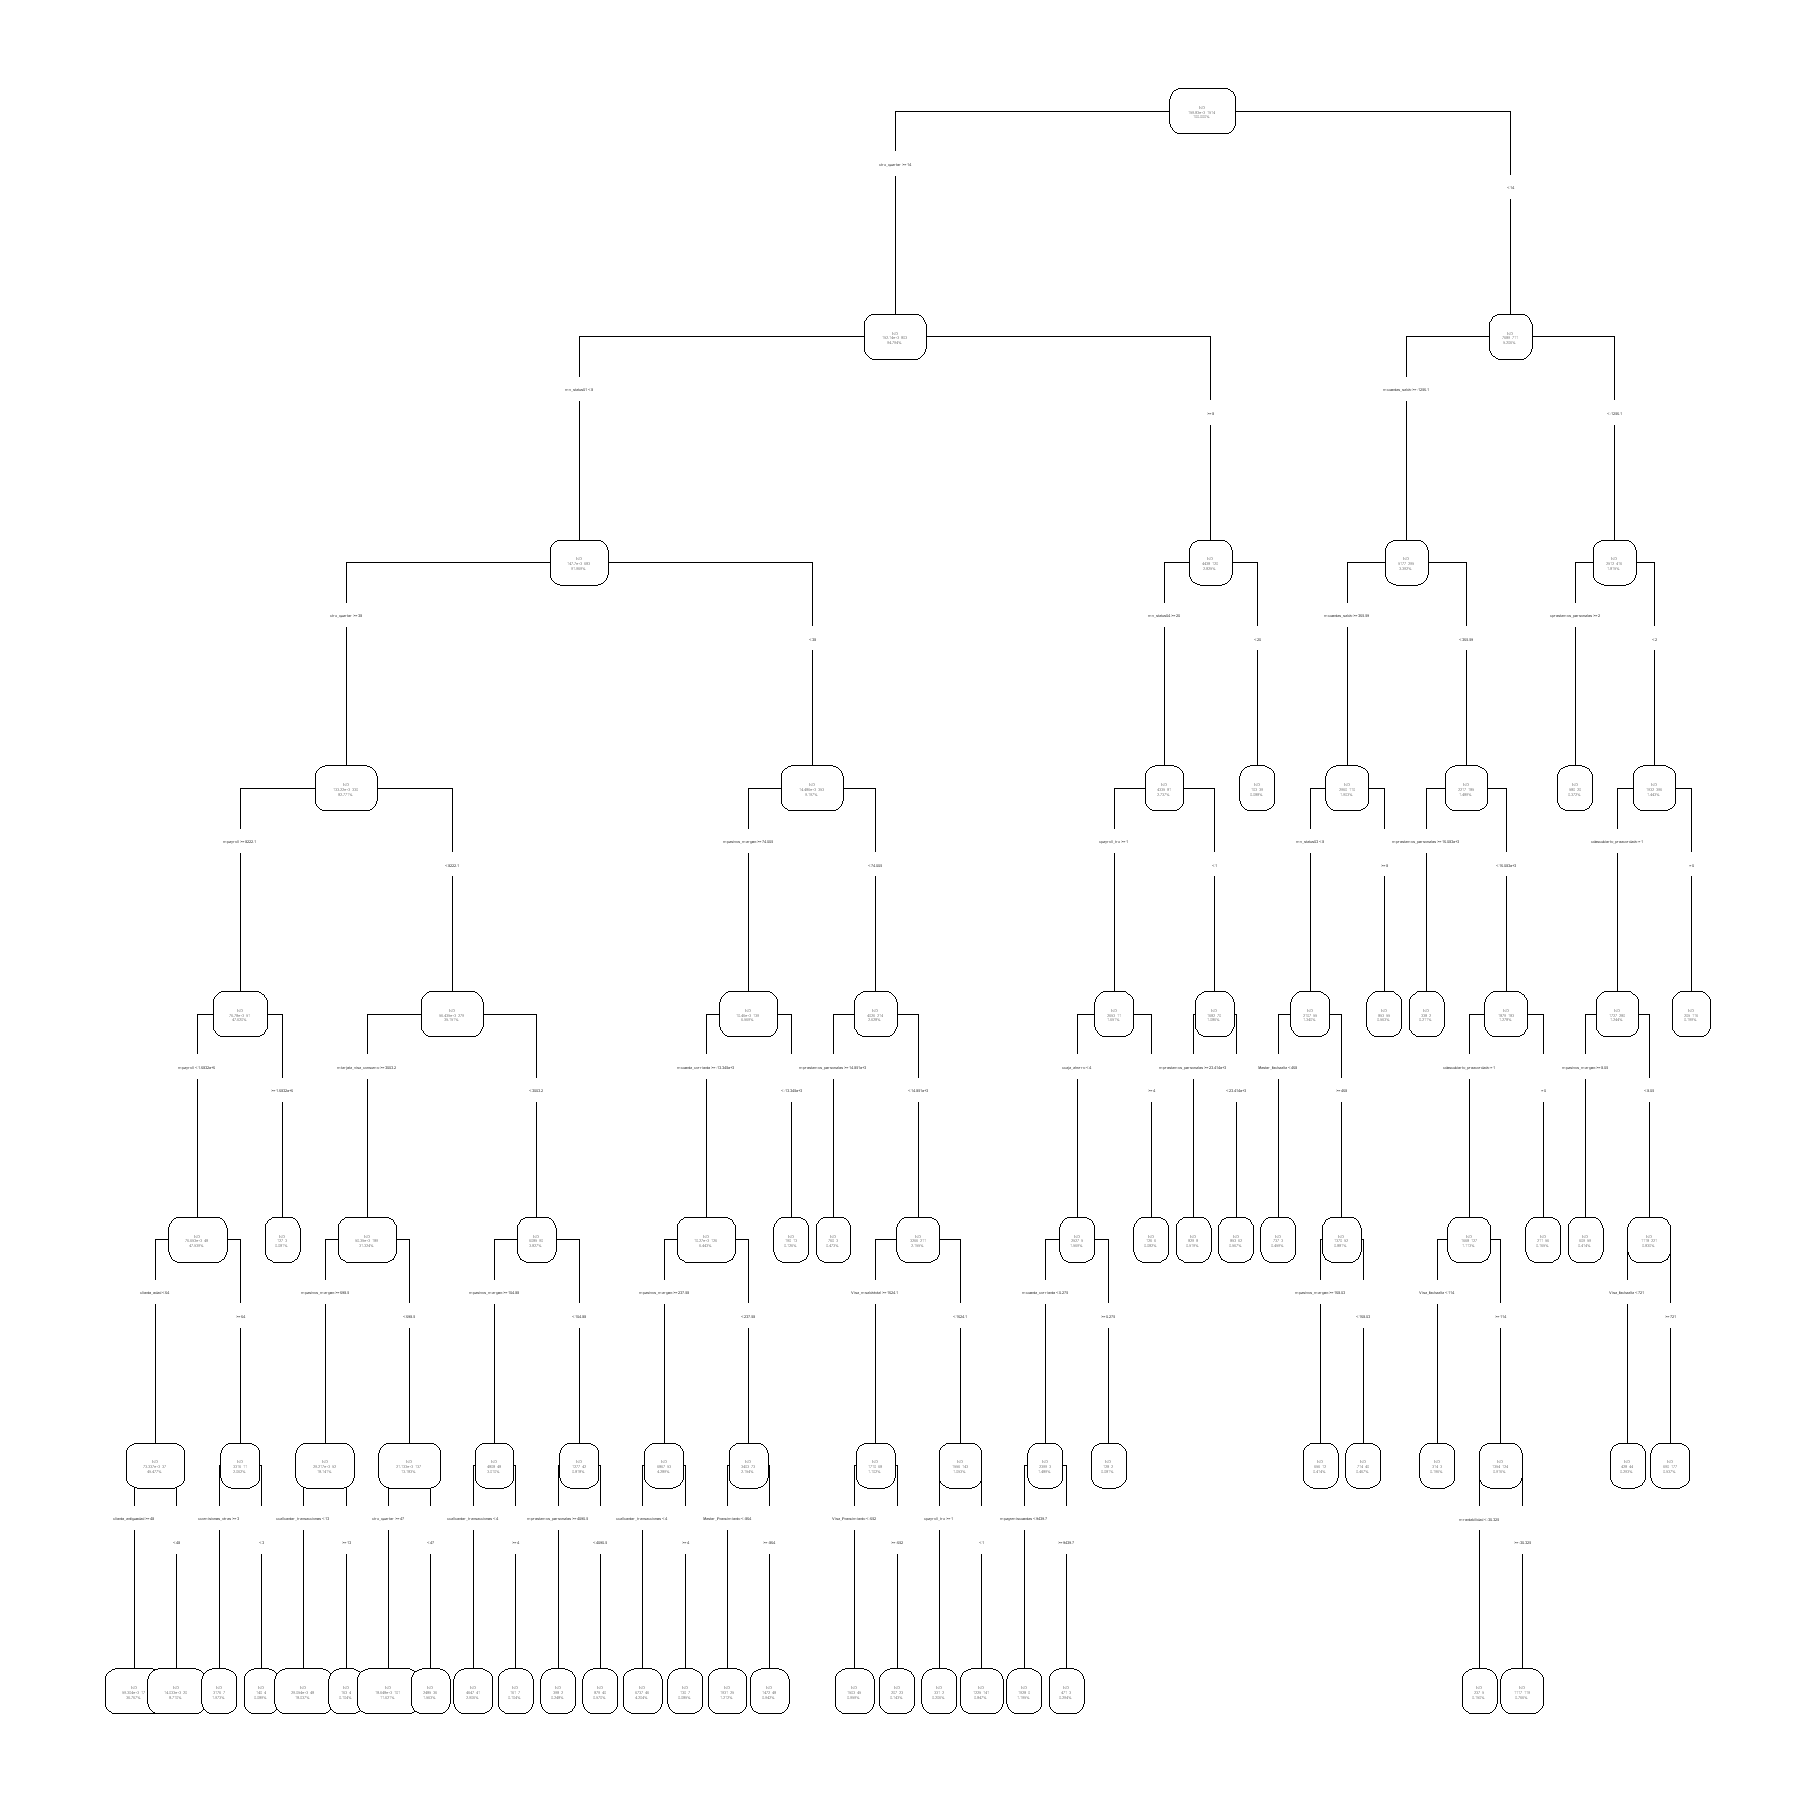

In [70]:
#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)